In [1]:
GDB = '/media/vineetb/DELTA/omuti_data/KreikeSampleExtractedDataNam52022.gdb/'
TIFF = '/media/vineetb/DELTA/omuti_data/Aerial1970_May12_2021_secondGCPsTest.tif'

In [2]:
import os.path
import fiona
import geopandas
import rasterio
import rasterio.plot
from rasterio.windows import Window
from rasterio.warp import calculate_default_transform, reproject, Resampling
import folium
import matplotlib.pyplot as plt

In [3]:
def subset(input_tif, output_tif, gdf, band_index=1, random=False, random_h=1000, random_w=5000):
    with rasterio.open(input_tif) as raster:
        if raster.crs.wkt != gdf.crs:
            raise AssertionError

        _minx, _miny, _maxx, _maxy = tuple(gdf.total_bounds)

        if random:
            _minx = np.random.randint(_minx, _maxx - random_w)
            _maxx = _minx + random_w
            _miny = np.random.randint(_miny, _maxy - random_h)
            _maxy = _miny + random_h

        _col_off1, _row_off1 = ~raster.transform * (_minx, _miny)
        _col_off2, _row_off2 = ~raster.transform * (_maxx, _maxy)

        _width, _height = _col_off2-_col_off1, _row_off1-_row_off2

        window = Window(
            float(_col_off1),
            float(_row_off2),
            float(_width),
            float(_height)
        )

        band = raster.read(
            band_index,
            window=window
        )

    os.makedirs(os.path.dirname(output_tif), exist_ok=True)
                
    with rasterio.open(
            output_tif,
            mode='w',
            driver='GTiff',
            height=band.shape[0],
            width=band.shape[1],
            count=1,
            dtype=band.dtype,
            crs=raster.crs.wkt,
            transform=rasterio.windows.transform(window, raster.transform),
    ) as new_dataset:
        new_dataset.write(band, indexes=1)

In [4]:
def reproject_tif(input_tif, output_tif, dst_crs='epsg:4326', output_png=None):
    with rasterio.open(input_tif) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        os.makedirs(os.path.dirname(output_tif), exist_ok=True)

        with rasterio.open(output_tif, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                destination, dst_transform = reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

    if output_png is not None:
        os.makedirs(os.path.dirname(output_png), exist_ok=True)
        with rasterio.open(output_tif) as dataset_in:
            arr = dataset_in.read()
            profile = dataset_in.profile
            profile['driver'] = 'PNG'

            with rasterio.open(output_png, 'w', **profile) as dataset_out:
                dataset_out.write(arr)

/tmp/ipykernel_58798/2873592972.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(africa.area['Angola'])  # world.area is a Series, indexed by the same index as the DataFrame (country)


103.59943926071931
['FarmBoundary1972', 'BigTree1972', 'Omuti1972', 'waterhole1972', 'FarmBoundary1943', 'BigTree1943', 'waterhole1943', 'Cattlekraal1943', 'Cattlekraal1972', 'Omuti1943', 'OldOmuti', 'OldOmuti1943', 'OldOmuti1972', 'Field1943']


<AxesSubplot:>

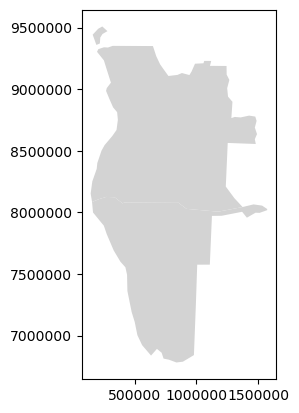

In [13]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Set index to the country name (unique)
world = world.set_index('name', drop=False)

africa = world[(world['continent'] == 'Africa')]
# Some attributes, like area/centroid/boundary, are available to us for 'world', since it has a geometry column
print(africa.area['Angola'])  # world.area is a Series, indexed by the same index as the DataFrame (country)

# The active geometry of a GeoDataFrame gives us a GeoSeries that we can plot/explore
# africa.plot()  # explore() works in jupyter
roi = africa[((africa['name'] == 'Angola') | (africa['name'] == 'Namibia'))]

layers = fiona.listlayers(GDB)
print(layers)
gdf = geopandas.read_file(GDB, layer='Omuti1972')

roi = roi.to_crs(gdf.crs)
fig, ax = plt.subplots(nrows=1, ncols=1, sharey='all', sharex='all')
ax.ticklabel_format(useOffset=False, style='plain')

roi.plot(ax=ax, color='lightgrey', edgecolor=None)

In [8]:
gdf.explore()

In [14]:
subset(TIFF, 'scratch/subset.tif', gdf)

In [8]:
reproject_tif(
    input_tif='scratch/subset.tif',
    output_tif='scratch/subset_reprojected.tif',
    output_png='scratch/subset_reprojected.png'
)

In [ ]:
raster_bounds = None
with rasterio.open('scratch/subset_reprojected.png') as raster:
    b = raster.bounds  # left, bottom, right, top
    raster_bounds = [[b[1], b[0]], [b[3], b[2]]]  # [[lat_min, lon_min], [lat_max, lon_max]]

geo_json1 = africa.geometry.to_json()
# Folium by default accepts lat/long (crs 4326) as input
geo_json2 = gdf.to_crs(epsg=4326).geometry.to_json()
geo_j1 = folium.GeoJson(data=geo_json1)
geo_j2 = folium.GeoJson(data=geo_json2)

map = folium.Map()
geo_j1.add_to(map)
geo_j2.add_to(map)

overlay = folium.raster_layers.ImageOverlay(
    name="Aerial Image",
    image='scratch/subset_reprojected.png',
    bounds=raster_bounds,
    interactive=True,
    cross_origin=True,
    zindex=0,
)
overlay.add_to(map)
folium.LayerControl().add_to(map)

map